In [75]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Think, what is the derivative of this function at any single point $x$? Usually, we derive the mathematical expression, but no one in Neural Networks writes out the full expression for Neural Nets, expression too big.

We look at the definition of a derivative, which is the slope of the response at a specific point. Pick $h=0.001$ for example. Below is just numerical approximation of the slope. If $x=3$, slope positive, if $x=-3$, slope negative. At $x=2/3$, slope is 0.

In [76]:
# Let's get more complex
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [77]:
h =  0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a * b + c

print('d1:', d1)
print('d2:', d2)
print('slope', (d2 - d1) / h)

d1: 4.0
d2: 4.0001
slope 0.9999999999976694


`__repr__` returns a string representation of an object (prints nicer looking expression, not something crypic). The `__add__` method is a special method in Python that defines the behavior of the + operator for objects of a class. `a.__add__(b)` is occurring.

In [78]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other - 1)) * out.grad
        out._backward = _backward

        return out

# To flip order if 2*a doesn't work
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self): 
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        n = self.data
        t = (math.exp(n) - math.exp(-n)) / (math.exp(n) + math.exp(-n))
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [79]:
a = Value(2.0)
2 * a

Value(data=4.0)

In [80]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

`._prev` simply prints the previous values (or nodes) used to compute a new value.

In [81]:
d._prev, d._op

({Value(data=-6.0), Value(data=10.0)}, '+')

In [82]:
from graphviz import Digraph

def trace(root):
    # builds a set of all modes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangilar ('record') node for it
        dot.node(name = uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

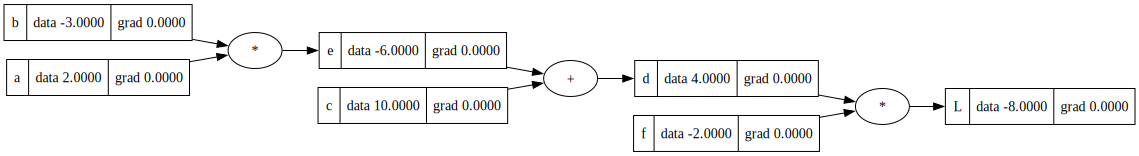

In [83]:
draw_dot(L)

We now try and define the derivative of L with respect to all the other variables. L is the loss function, derivative with respect to weights of the neural network, need to know how weights are impacting loss function.

(see above), initialisation, grad = 0, variable has no effect

We can think of + nodes as routing the gradient, as the local gradient is just 1 e.g. d = c+e, dd/dc = 1

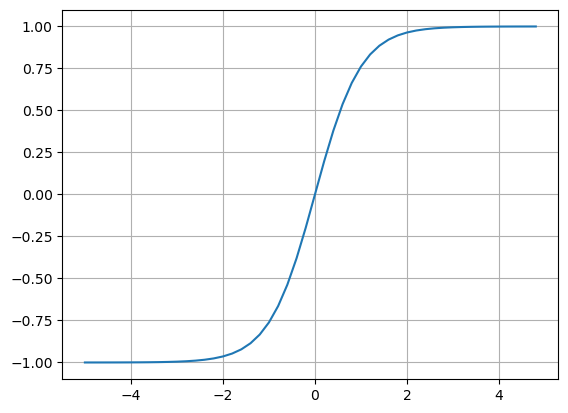

In [84]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [85]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
# done step-by-step to have pointers
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e-1)/(e+1)
o.label = 'o'

In [86]:
o.backward()

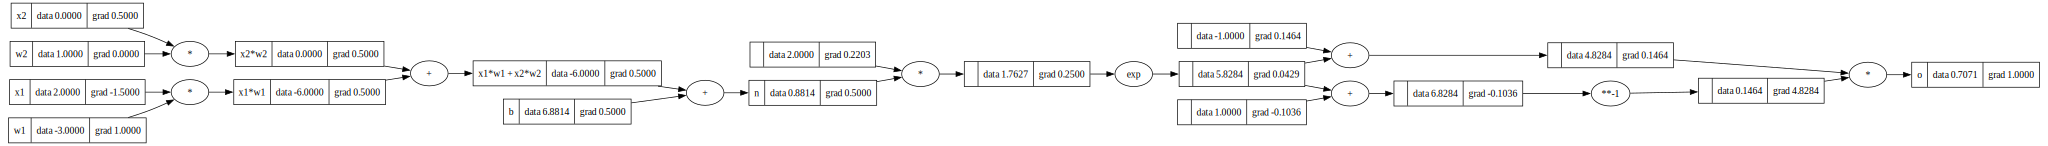

In [87]:
draw_dot(o)

Need to initialise o.grad = 1.0, as we initialise with o.grad = 0.0

Everything has to be propagated before backpropagation is done.

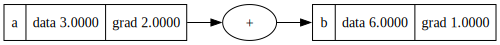

In [88]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

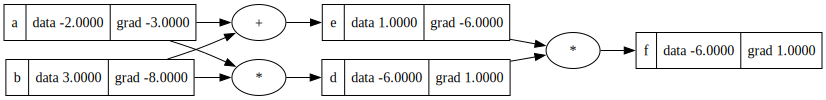

In [89]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()
draw_dot(f)

In [90]:
import torch

.item takes the element, and strips out the tensor

In [91]:
x1 = torch.tensor([2.0]).double(); x1.requires_grad=True
x2 = torch.tensor([0.0]).double(); x2.requires_grad=True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad=True
w2 = torch.tensor([1.0]).double(); w2.requires_grad=True
b = torch.tensor([6.8813735870195432]).double(); b.requires_grad=True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [92]:
torch.Tensor([2.0]).double().dtype

torch.float64

In [93]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [94]:
import random

n(x) is the call function

In [156]:
class Neuron:
  
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
  
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
  
    def parameters(self):
        return self.w + [self.b]

class Layer:
  
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
  
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
  
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [157]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.48184700936639113)

In [158]:
n.parameters()

[Value(data=-0.8319497280519457),
 Value(data=-0.8623040308695282),
 Value(data=0.0879554813381731),
 Value(data=-0.35811958408292544),
 Value(data=-0.016245299671435953),
 Value(data=-0.052901677281822046),
 Value(data=0.954557603811838),
 Value(data=-0.4338592002233612),
 Value(data=0.10246861670139751),
 Value(data=-0.7111856621986212),
 Value(data=0.5641669486941936),
 Value(data=0.9905680136787114),
 Value(data=0.06807719870537232),
 Value(data=-0.27402826321238405),
 Value(data=-0.9826836536186299),
 Value(data=-0.4307779258421085),
 Value(data=-0.8634420092317967),
 Value(data=0.8687399951921768),
 Value(data=0.16111395815342555),
 Value(data=0.8784742833367549),
 Value(data=-0.07560831664517287),
 Value(data=-0.7839116546588545),
 Value(data=0.507936198992494),
 Value(data=-0.3658403625204427),
 Value(data=-0.7489738188593096),
 Value(data=0.9833952797611771),
 Value(data=0.76254195812635),
 Value(data=-0.6749922868126659),
 Value(data=-0.2729686755758478),
 Value(data=0.587273

In [159]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets (binary classifier)

ypred = [n(x) for x in xs]
ypred

[Value(data=0.48184700936639113),
 Value(data=0.1967113925699105),
 Value(data=0.3952364761575736),
 Value(data=0.39650581202995533)]

In [160]:
for p in n.parameters():
    p.data -= 0.01 * p.grad

Need to set p.grad = 0.0, so they reset to 0, otherwise they keep adding

In [161]:
for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update weights
    for p in n.parameters():
        p.data -= 0.05 * p.grad
    
    print(k, loss.data)

0 4.011490738123394
1 1.713086746876066
2 0.9531244790804543
3 0.5579722129116077
4 0.3782959646722678
5 0.27706152130993167
6 0.21389440419582081
7 0.17169048072545304
8 0.141952549411895
9 0.12010438932611389
10 0.10350712387900793
11 0.09055060245670726
12 0.08020531400892607
13 0.07178674522918338
14 0.06482446324178534
15 0.05898588641353879
16 0.05403007201069644
17 0.04977870532598584
18 0.04609732362909417
19 0.0428828337957342
